In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

Setup following Early et al. 2011, JPO

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'rossby_wave'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

init_with_geostrophic_adjustment = True
do_upwind_advection = True

fac = 1
dt_fac = 0.5
nx = 200*fac
ny = 120*fac
nt = int(180000*fac/dt_fac)
#nt = 10

picture_frequency = 0
output_frequency = 240
diagnostic_frequency = 240

x0 = -1500e3
y0 = -600e3
dx = 10e3
dy = dx
#dt = 360.

#grav = 9.81
grav = 0.01
rho = np.array([1024.])
nz = rho.size

H0 = 800.
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
#dt  = dt_fac * 0.1*dx/np.sqrt(grav*H0)
dt = dt_fac * 360.

nspx = 1
nspy = 1
epsab = 0.01

U0 = 1e-3
iRe = 5e-4
iRe = float(iRe)
do_height_diffusion = False # (since we have 1st order upwind adv. scheme)
kh = 0.
# kh = iRe*U0*dx
Ah = iRe*U0*dx

#f0 = 1e-4
#beta = 1e-11
R_earth = 6371e3
f0 = 2 * 2*np.pi/86400*np.sin(24.*np.pi/180.)
beta = 2 * 2*np.pi/86400/R_earth * np.cos(24.*np.pi/180.)
#Y0 = ny*dy/2.

Lr = np.sqrt(grav*H0)/f0
c_grav = np.sqrt(grav*H0)
c_ross = -beta*Lr**2

Eta0 = 100.
N0 = 150.
L0 = 80e3
U0 = grav*Eta0/(f0*Lr)
beta_nli = U0/(beta*Lr**2)

do_linear_height_advection = True
do_momentum_advection = False
do_momentum_diffusion = True
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_height_advection = True

In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
#ho0 = 0.01*(Xt-Lx/2.)/Lx
#ho0 = H0+0.1*np.sin(Xt/(Lx+dx)*2*np.pi*2)
#L2 = 1.e-3*(Lx**2+Ly**2)
ho0 = H0+N0*np.exp(-(Xt**2+Yt**2)/L0**2)
ho0 = ho0[np.newaxis,:,:]
#H0 = 0.
#ho0 += H0

#uo0 = cph + 0.*Xu
#uo0 = uo0[np.newaxis,:,:]
if init_with_geostrophic_adjustment:
  vo0 =  grav/f0 * N0 * (-2*Xt/L0**2) * np.exp(-(Xt**2+Yu**2)/L0**2)
  uo0 = -grav/f0 * N0 * (-2*Yt/L0**2) * np.exp(-(Xu**2+Yt**2)/L0**2)
  uo0 = uo0[np.newaxis,:,:]
  vo0 = vo0[np.newaxis,:,:]

maskt0[:,:,0] = 0.
maskt0[:,:,-1] = 0.
maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.

ix = np.array([nx//2])
iy = np.array([ny//2])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())


KeyboardInterrupt



## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [23]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    flist = glob.glob(f'{path_data}/{file_prfx}_????.nc')
    flist.sort()
    ds = xr.open_mfdataset(flist, **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/rossby_wave//test_combined.nc
CPU times: user 7.83 s, sys: 1.43 s, total: 9.26 s
Wall time: 7.93 s


## Plot overview

In [24]:
nps = ds.time.size
nps

291

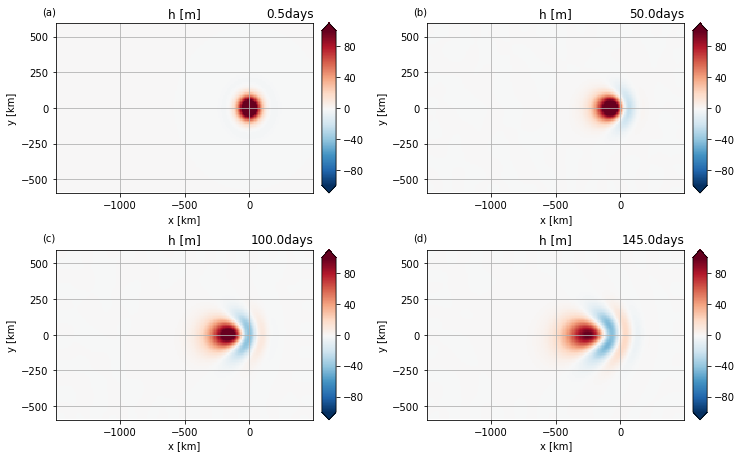

In [50]:
# prepare the animation
iz = 0
steps = [1, 100, 200, 290]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=0.66, fig_size_fac=1.5, 
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    clim = 100.
    hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
    ax.grid(True)

## Make an animation

In [51]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

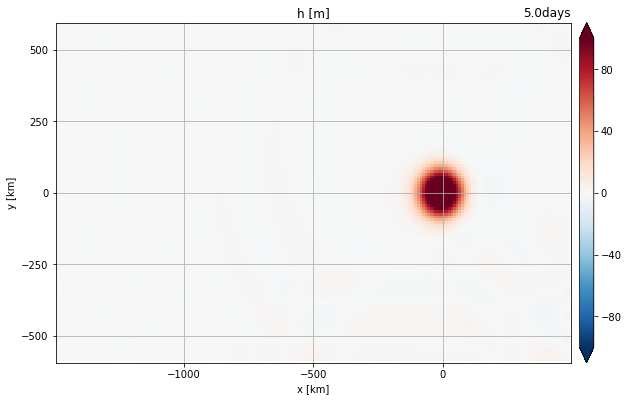

In [53]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=0.66, fig_size_fac=3, axlab_kw=None,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = 100.
hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
ax.grid(True)

In [54]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [55]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/rossby_wave///<function run at 0x162a0fd30>.mp4
CPU times: user 17.8 s, sys: 6.27 s, total: 24 s
Wall time: 24.3 s


## Showing the animation

In [56]:
%%time
HTML(ani.to_jshtml())

CPU times: user 21.4 s, sys: 6.29 s, total: 27.7 s
Wall time: 27.7 s
